In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # or RandomForestRegressor, depending on your target
from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('output.csv')
df.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,file,month,day,year,day_of_week,start_hour,ride_length,ride_km,rider_speed
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,...,member,202205-divvy-tripdata.csv,5,23,2022,Monday,23,33.35,6.30,0.0
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,...,member,202205-divvy-tripdata.csv,5,11,2022,Wednesday,8,37.90,0.61,0.0


In [4]:
# Round latitude and longitude to 4 decimal places so do not treat similar coordinates as different locations 
df['start_lat'] = df['start_lat'].round(4)
df['start_lng'] = df['start_lng'].round(4)
df['end_lat'] = df['end_lat'].round(4)
df['end_lng'] = df['end_lng'].round(4)


In [5]:
# drop unnecessary columns
df = df.drop(columns=['file', 'started_at', 'ended_at', 
                      'year', 'start_station_id', 'end_station_id', 'start_station_name', 'end_station_name', 'day'])
# remove missing data from 
df.dropna(subset=['ride_km', 'rider_speed', 'end_lat', 'end_lng'], axis=0, inplace=True)


In [6]:
df.columns

Index(['ride_id', 'rideable_type', 'start_lat', 'start_lng', 'end_lat',
       'end_lng', 'member_casual', 'month', 'day_of_week', 'start_hour',
       'ride_length', 'ride_km', 'rider_speed'],
      dtype='object')

In [7]:
# Convert target: 'member_casual' to binary format
df['is_member'] = (df['member_casual'] == 'member').astype(int)

In [8]:
# Select independent variables
categorical_features = ['rideable_type', 'day_of_week']
numeric_features = ['start_hour', 'ride_length', 'ride_km', 'rider_speed',
                    'start_lat', 'start_lng', 'end_lat', 'end_lng', 'month']

In [9]:
# encode categorical variables dynamically 
prefixes = ['rideable', 'day']
for feature, prefix in zip(categorical_features, prefixes):
    df = pd.get_dummies(df, columns=[feature], prefix=prefix)

In [10]:
# Get all the features from df after get_dummies
all_features = df.columns.tolist()

# Remove the features which are not used as predictors
all_features.remove('is_member')
all_features.remove('member_casual')
all_features.remove('ride_id')

# Now, all_features contains all the feature names for the model
features = all_features


In [11]:
# Create features (X) and target (y). Target = predict is_member

y = df['is_member']
X = df[features]

In [12]:
# Set random state seed
r = 42

# First split to separate out the training set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=r)

# Second split to separate out the test and development set
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=r)

# Now I have your training set (X_train, y_train), development/validation set (X_dev, y_dev), and test set (X_test, y_test)

In [13]:
# Check the distribution of membership in the training set
membership_distribution = y_train.value_counts(normalize=True)

print(membership_distribution)


1    0.566712
0    0.433288
Name: is_member, dtype: float64


In [14]:
# untuned forest
untuned_forest = RandomForestClassifier(n_estimators=10, random_state=r)
# fit model
untuned_forest.fit(X_train, y_train)

# 
print("Untuned accuracy Random Forest:",untuned_forest.score(X_dev, y_dev))

# find the largest tree depth of all estimators in the forest
max_tree_depth_in_forest = max([estimator.tree_.max_depth for estimator in untuned_forest.estimators_])

Untuned accuracy Random Forest: 0.7136741922658242


In [15]:
# untuned forest
untuned_forest = RandomForestClassifier(n_estimators=10, random_state=r)
# fit model
untuned_forest.fit(X_train, y_train)

# 
print("Untuned accuracy Random Forest:",untuned_forest.score(X_dev, y_dev))

# find the largest tree depth of all estimators in the forest
max_tree_depth_in_forest = max([estimator.tree_.max_depth for estimator in untuned_forest.estimators_])

Untuned accuracy Random Forest: 0.7136741922658242


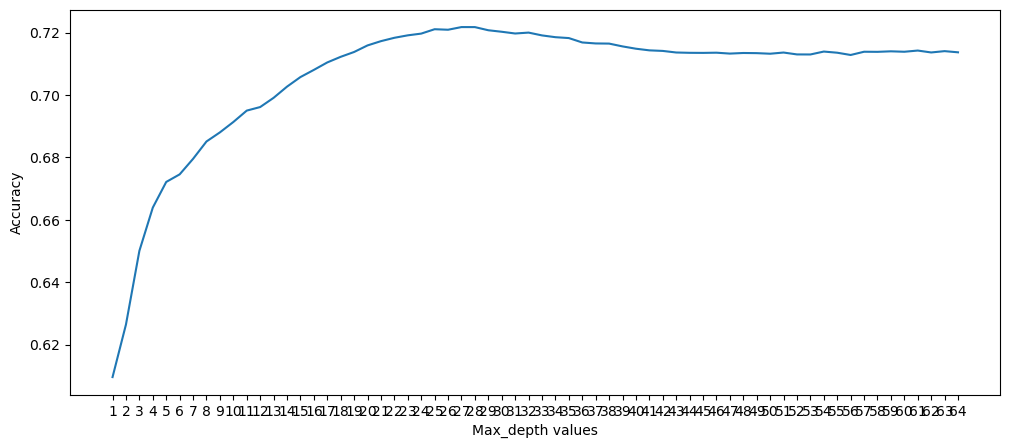

Best performance reached at depth of: 27


In [16]:
# recalculate accuracy for depths between 1 and max_tree_depth_in_forest
pruned_scores = [] 
pruned_depths = range(1, max_tree_depth_in_forest + 1)
for d in pruned_depths:
  forest = RandomForestClassifier(n_estimators=10, random_state=r, max_depth=d)
  forest.fit(X_train, y_train)
  score = forest.score(X_dev, y_dev)
  pruned_scores.append(score)

# plot the outcome
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(pruned_depths, pruned_scores)
plt.xlabel("Max_depth values")
plt.ylabel("Accuracy")  # Corrected here
ax.xaxis.set_ticks(pruned_depths)
plt.show()

# fitting the chosen tree using test set
best_depth = pruned_depths[np.argmax(pruned_scores)]
print('Best performance reached at depth of:', best_depth)

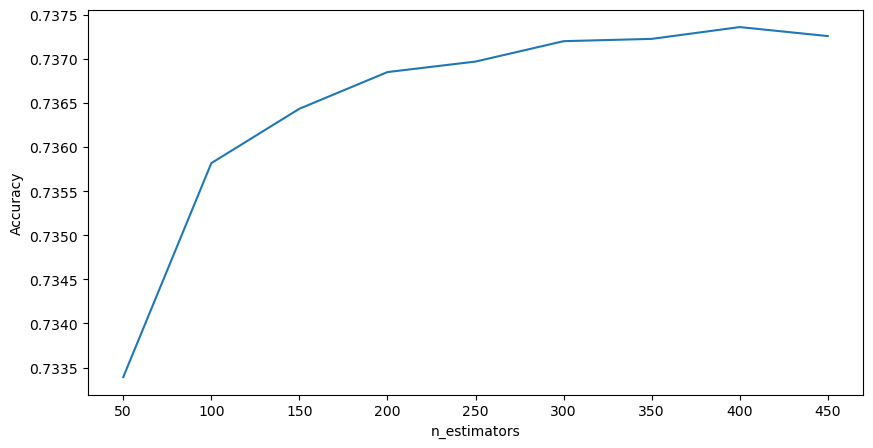

Best performance reached at estimator count of: 400


In [17]:
# create a list of estimator counts between 50 and 500
n_estimators = range(50, 500, 50)

# run classifier for each estimator count, record accuracy
estimator_scores = [] 
for n in n_estimators:
  forest = RandomForestClassifier(n_estimators=n, random_state=r, max_depth=best_depth)
  forest.fit(X_train, y_train)
  score = forest.score(X_dev, y_dev)
  estimator_scores.append(score)

# plot the outcome
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_estimators, estimator_scores)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")  # Corrected here
ax.xaxis.set_ticks(n_estimators)
plt.show()

# calculate and display the best number of estimators based on results
best_estimator = n_estimators[np.argmax(estimator_scores)]
print('Best performance reached at estimator count of:', best_estimator)

In [19]:
# rerunning the model with the tuned tree depth value and tuned estimator count
forest = RandomForestClassifier(n_estimators=best_estimator, random_state=r, max_depth=best_depth)
forest.fit(X_train, y_train)
# evaluate model
y_pred = forest.predict(X_test)

# output the old vs new accuracy scores
print("Untuned accuracy:",untuned_forest.score(X_dev, y_dev))
print("Tuned accuracy:",forest.score(X_test, y_test))

# compute the error between our test predictions and the actual values.
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print regression metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Untuned accuracy: 0.7136741922658242
Tuned accuracy: 0.7379784302153694
Mean Absolute Error: 0.26202156978463065
Mean Squared Error: 0.26202156978463065
R-squared: -0.06670906880445604


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Casual', 'Actual Member'], columns=['Predicted Casual', 'Predicted Member'])
print(cm_df)


              precision    recall  f1-score   support

           0       0.74      0.61      0.67    383082
           1       0.74      0.84      0.78    499727

    accuracy                           0.74    882809
   macro avg       0.74      0.72      0.73    882809
weighted avg       0.74      0.74      0.73    882809

               Predicted Casual  Predicted Member
Actual Casual            233738            149344
Actual Member             81971            417756


Overall, the model is performing decently in predicting rider types, achieving accuracy in 74% of instances, with a particular strength in identifying Members as opposed to Casual users. One potential strategy for leveraging these results could be to target the False Positives - those Casual riders who have been misclassified as Members. These users exhibit traits typical of Members, hence marketing efforts could be employed to encourage them to convert their status from Casual to Member. 

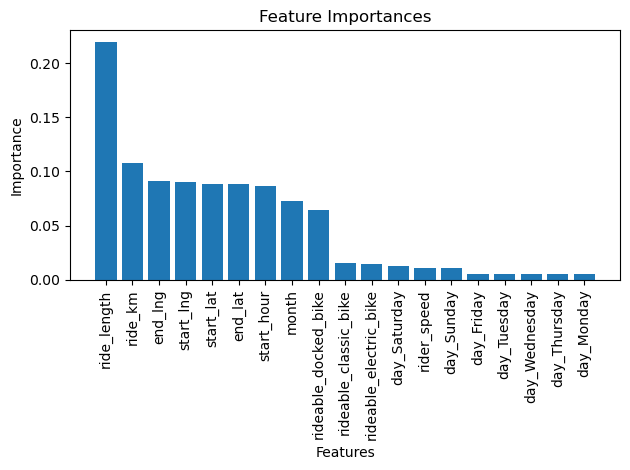

In [21]:

# Get feature importance from the model
importance = forest.feature_importances_

# Get the names of the predictor variables
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]

# Plot feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importance[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

ROC Curve: This plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, and can help you understand the trade-off between correctly identifying positives and incorrectly identifying negatives. The area under the ROC curve (AUC-ROC) is a measure of the model's performance; a perfect model has an AUC-ROC of 1, while a random model has an AUC-ROC of 0.5.

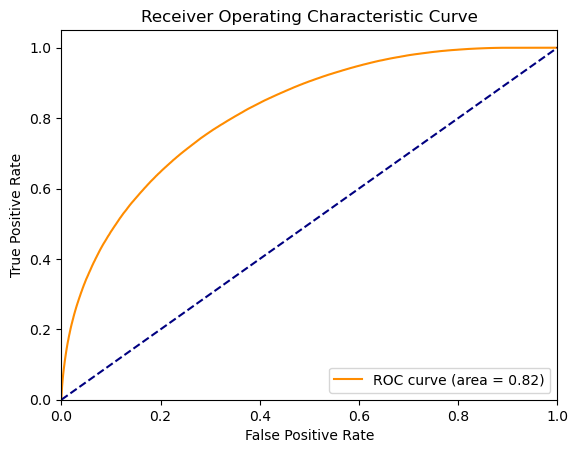

In [22]:
from sklearn.metrics import roc_curve, auc
y_scores = forest.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['squared_error', 'squared_error']
# }

# rf_cv = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 5)
# rf_cv.fit(X_train, y_train)

# print("Best Parameters are: ", rf_cv.best_params_)

# y_pred = rf_cv.predict(X_test)

# # output the old vs new accuracy scores
# print(rf_cv.score(X_dev, y_dev))

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# # Print regression metrics
# print("Mean Absolute Error:", mae)
# print("Mean Squared Error:", mse)
# print("R-squared:", r2)

Below are the ride ids of casual riders who were miss classified as member riders.  These casuals riders may share a similar profile to the member riders and therefore may be a great candidate for targeting marketing for converting to membership. 

In [23]:

# Train the model using the entire dataset
forest.fit(df[features], df['is_member'])

# Apply the model to the entire dataset
df['predicted'] = forest.predict(df[features])

# Find the instances where casual riders were predicted as members
potential_members = df[(df['predicted'] == 1) & (df['is_member'] == 0)]

# Get the indices of these instances
potential_member_indices = potential_members.index

# Map these indices back to the original 'ride_id'
potential_member_rider_ids = df.loc[potential_member_indices, 'ride_id']
print(f'{len(potential_member_rider_ids)} potential riders to target for member rider.')


482589 potential riders to target for member rider.


In [ ]:
# predict_df = pd.DataFrame(data)

# # Ensure that the features are in the same order as during training
# predict_df = predict_df[data.keys()]

# # Use the model to predict the target outcome
# predictions = forest.predict(predict_df)

# # Print the predictions
# print( f'predicted membership type {predictions}' ) 